In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from typing import List, Union 
from tqdm import tqdm

In [2]:
def get_permutation(
        ohlcc : Union[pd.DataFrame, List[pd.DataFrame]],
        start_index : int = 0, 
        seed = None) :
    
    ohlc = ohlcc.copy()
    assert start_index >= 0

    np.random.seed(seed)

    if isinstance(ohlc, list):
        time_index = ohlc[0].index
        for mkt in ohlc:
            assert np.all(time_index == mkt.index), "Indexes do not match"
        n_markets = len(ohlc)
    else:
        n_markets = 1
        time_index = ohlc.index
        ohlc = [ohlc]

    n_bars = len(ohlc[0])

    perm_index = start_index + 1
    perm_n = n_bars - perm_index

    start_bar = np.empty((n_markets, 4))
    relative_Open = np.empty((n_markets, perm_n))
    relative_High = np.empty((n_markets, perm_n))
    relative_Low = np.empty((n_markets, perm_n))
    relative_Close = np.empty((n_markets, perm_n))
    
    for mkt_i, reg_bars in enumerate(ohlc):
        log_bars = np.log(reg_bars[['Open', 'High', 'Low', 'Close']])

        # Get start bar
        start_bar[mkt_i] = log_bars.iloc[start_index].to_numpy()

        # Open relative to last Close
        r_o = (log_bars['Open'] - log_bars['Close'].shift()).to_numpy().flatten()
        
        # Get prices relative to this bars Open
        r_h = (log_bars['High'] - log_bars['Open']).to_numpy().flatten()
        r_l = (log_bars['Low'] - log_bars['Open']).to_numpy().flatten()
        r_c = (log_bars['Close'] - log_bars['Open']).to_numpy().flatten()

        relative_Open[mkt_i] = r_o[perm_index:]
        relative_High[mkt_i] = r_h[perm_index:]
        relative_Low[mkt_i] = r_l[perm_index:]
        relative_Close[mkt_i] = r_c[perm_index:]

    idx = np.arange(perm_n)

    # Shuffle intrabar relative values (High/Low/Close)
    perm1 = np.random.permutation(idx)
    relative_High = relative_High[:, perm1]
    relative_Low = relative_Low[:, perm1]
    relative_Close = relative_Close[:, perm1]

    # Shuffle last Close to Open (gaps) seprately
    perm2 = np.random.permutation(idx)
    relative_Open = relative_Open[:, perm2]

    # Create permutation from relative prices
    perm_ohlc = []
    for mkt_i, reg_bars in enumerate(ohlc):
        perm_bars = np.zeros((n_bars, 4))

        # Copy over real data before start index 
        log_bars = np.log(reg_bars[['Open', 'High', 'Low', 'Close']]).to_numpy().copy()
        perm_bars[:start_index] = log_bars[:start_index]
        
        # Copy start bar
        perm_bars[start_index] = start_bar[mkt_i]

        for i in range(perm_index, n_bars):
            k = i - perm_index
            perm_bars[i, 0] = perm_bars[i - 1, 3] + relative_Open[mkt_i][k]
            perm_bars[i, 1] = perm_bars[i, 0] + relative_High[mkt_i][k]
            perm_bars[i, 2] = perm_bars[i, 0] + relative_Low[mkt_i][k]
            perm_bars[i, 3] = perm_bars[i, 0] + relative_Close[mkt_i][k]

        perm_bars = np.exp(perm_bars)
        perm_bars = pd.DataFrame(perm_bars, index=time_index, columns=['Open', 'High', 'Low', 'Close'])

        perm_ohlc.append(perm_bars)

    if n_markets > 1:
        return perm_ohlc
    else:
        return perm_ohlc[0]

/var/folders/6x/40f088zn6lb1tw1zn99534440000gn/T/ipykernel_15422/2478699776.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_real = yf.download(symbol_1, start = '2016-01-31', end = '2020-01-31', interval="1d")
[*********************100%***********************]  1 of 1 completed
/var/folders/6x/40f088zn6lb1tw1zn99534440000gn/T/ipykernel_15422/2478699776.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eth_real = yf.download(symbol_2, start = '2016-01-31', end = '2020-01-31', interval="1d")
[*********************100%***********************]  1 of 1 completed


Mean. REAL:      -0.000879 PERM:      -0.000879
Stdd. REAL:       0.039368 PERM:       0.039309
Skew. REAL:      -0.250673 PERM:      -0.263761
Kurt. REAL:       3.078790 PERM:       3.133311



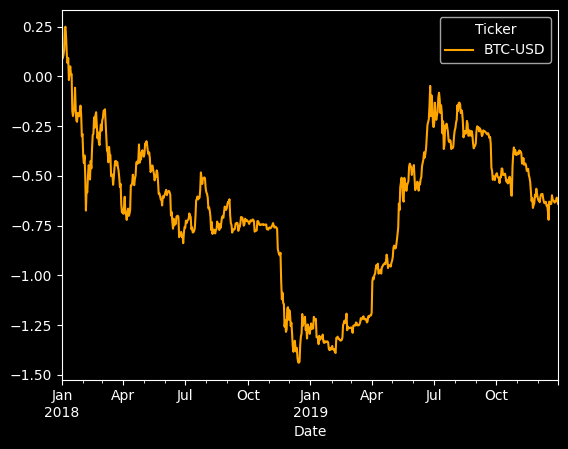

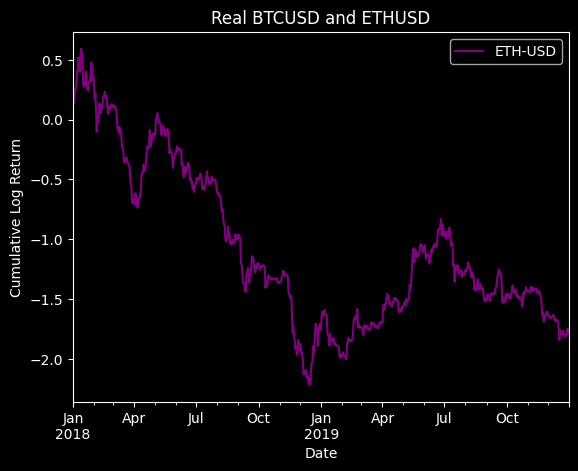

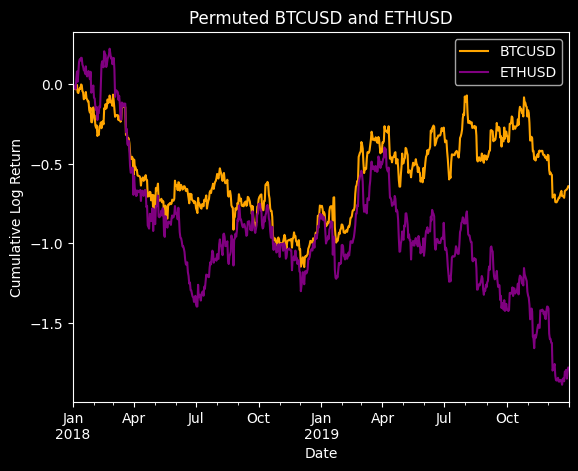

In [3]:
symbol_1 = 'BTC-USD'

btc_real = yf.download(symbol_1, start = '2016-01-31', end = '2020-01-31', interval="1d")
btc_real.index = btc_real.index.astype('datetime64[s]')
mask = ((btc_real.index.year >= 2018) & (btc_real.index.year <  2020))
btc_real = btc_real.loc[mask]

btc_perm = get_permutation(btc_real)

btc_real_r = np.log(btc_real['Close']).diff().squeeze()
btc_perm_r = np.log(btc_perm['Close']).diff().squeeze()

print(f"Mean. REAL: {btc_real_r.mean():14.6f} PERM: {btc_perm_r.mean():14.6f}")
print(f"Stdd. REAL: {btc_real_r.std():14.6f} PERM: {btc_perm_r.std():14.6f}")
print(f"Skew. REAL: {btc_real_r.skew():14.6f} PERM: {btc_perm_r.skew():14.6f}")
print(f"Kurt. REAL: {btc_real_r.kurt():14.6f} PERM: {btc_perm_r.kurt():14.6f}")

symbol_2 = "ETH-USD"
eth_real = yf.download(symbol_2, start = '2016-01-31', end = '2020-01-31', interval="1d")
eth_real.index = eth_real.index.astype('datetime64[s]')
mask2 = ((eth_real.index.year >= 2018) & (eth_real.index.year <  2020))
eth_real = eth_real.loc[mask2]
eth_real_r = np.log(eth_real['Close']).diff()

print("") 

permed = get_permutation([btc_real, eth_real])
btc_perm = permed[0]
eth_perm = permed[1]
    
btc_perm_r = np.log(btc_perm['Close']).diff().squeeze()
eth_perm_r = np.log(eth_perm['Close']).diff().squeeze()

#print(type(btc_perm_r), getattr(btc_perm_r, "shape", None))
#print(type(eth_perm_r), getattr(eth_perm_r, "shape", None))

plt.style.use("dark_background")    
np.log(btc_real['Close']).diff().cumsum().plot(color='orange', label='BTCUSD')
np.log(eth_real['Close']).diff().cumsum().plot(color='purple', label='ETHUSD')

plt.ylabel("Cumulative Log Return")
plt.title("Real BTCUSD and ETHUSD")
plt.legend()
plt.show()

np.log(btc_perm['Close']).diff().cumsum().plot(color='orange', label='BTCUSD')
np.log(eth_perm['Close']).diff().cumsum().plot(color='purple', label='ETHUSD')
plt.title("Permuted BTCUSD and ETHUSD")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.show()

In [ ]:
from MACOPY import MA_CROSSOVER, OPTI_MACO, walkforward_MA

In [ ]:
symb = 'BTC-USD'
df = yf.download(symb, start = '2016-01-31', end = '2020-01-31', interval="1d")
df.index = df.index.astype('datetime64[s]')
mask = ((df.index.year >= 2018) & (df.index.year <  2020))

train_df = df.loc[mask]
best_lookback1, best_lookback2, best_real_pf = OPTI_MACO(train_df)
print("In-sample PF", best_real_pf, "Best Lookback 1", best_lookback1, "Best Lookback 2", best_lookback2)


n_permutations = 1000
perm_better_count = 1
permuted_pfs = []
print("In-Sample MCPT")
for perm_i in tqdm(range(1, n_permutations)):
    train_perm = get_permutation(train_df)
    _, _, best_perm_pf = OPTI_MACO(train_perm)

    if best_perm_pf >= best_real_pf:
        perm_better_count += 1

    permuted_pfs.append(best_perm_pf)

insample_mcpt_pval = perm_better_count / n_permutations
print(f"In-sample MCPT P-Value: {insample_mcpt_pval}")

plt.style.use('dark_background')
pd.Series(permuted_pfs).hist(color='blue', label='Permutations')
plt.axvline(best_real_pf, color='red', label='Real')
plt.xlabel("Profit Factor")
plt.title(f"In-sample MCPT. P-Value: {insample_mcpt_pval}")
plt.grid(False)
plt.legend()
plt.show()

/var/folders/6x/40f088zn6lb1tw1zn99534440000gn/T/ipykernel_15422/886726886.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symb, start = '2016-01-31', end = '2020-01-31', interval="1d")
[*********************100%***********************]  1 of 1 completed


In-sample PF 1.3831642589706532 Best Lookback 1 94 Best Lookback 2 115
In-Sample MCPT


 22%|██▏       | 222/999 [22:25<1:16:54,  5.94s/it]

In [ ]:
mask2 = ((df.index.year >= 2016) & (df.index.year <  2020))
train_df = df.loc[mask2]
train_df['r'] = np.log(train_df['Close']).diff().shift(-1)
train_window = 365 
train_df['MA_wf_signal'] = walkforward_MA(train_df, train_lookback=train_window)

MA_rets = train_df['MA_wf_signal'] * train_df['r']
real_wf_pf = MA_rets[MA_rets > 0].sum() / MA_rets[MA_rets < 0].abs().sum()

n_permutations = 200
perm_better_count = 1
permuted_pfs = []
print("Walkforward MCPT")
for perm_i in tqdm(range(1, n_permutations)):
    wf_perm = get_permutation(train_df, start_index=train_window)
    
    wf_perm['r'] = np.log(wf_perm['Close']).diff().shift(-1) 
    wf_perm_sig = walkforward_MA(wf_perm, train_lookback=train_window)
    perm_rets = wf_perm['r'] * wf_perm_sig
    perm_pf = perm_rets[perm_rets > 0].sum() / perm_rets[perm_rets < 0].abs().sum()
    
    if perm_pf >= real_wf_pf:
        perm_better_count += 1

    permuted_pfs.append(perm_pf)


walkforward_mcpt_pval = perm_better_count / n_permutations
print(f"Walkforward MCPT P-Value: {walkforward_mcpt_pval}")
plt.style.use('dark_background')
pd.Series(permuted_pfs).hist(color='blue', label='Permutations')
plt.axvline(real_wf_pf, color='red', label='Real')
plt.xlabel("Profit Factor")
plt.title(f"Walkforward MCPT. P-Value: {walkforward_mcpt_pval}")
plt.grid(False)
plt.legend()
plt.show()


/var/folders/6x/40f088zn6lb1tw1zn99534440000gn/T/ipykernel_12477/2235673884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['r'] = np.log(train_df['Close']).diff().shift(-1)
/var/folders/6x/40f088zn6lb1tw1zn99534440000gn/T/ipykernel_12477/2235673884.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['MA_wf_signal'] = walkforward_MA(train_df, train_lookback=train_window)


Walkforward MCPT


 49%|████▉     | 98/199 [3:58:31<20:42, 12.30s/it]     